# 03a At Only Data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle 
import time 

from scipy import stats

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

from collections import Counter

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

## Notebook parameters

In [2]:
nb_id = f'03a'
nb_long_id = f'{nb_id}_At'
num_classes = 10
random_state = 42

## Load data

In [3]:
# load complete training dataframe
df = pd.read_pickle("./01_AtBot_data.pkl")
print(f"Number of data samples: {len(df)}")
print(f"Number of features: {len(df.columns)-6}")

# extract feature names from RNASeq data
gene_names = list(df)[6:29107]

# Arabidopsis only feature gene set
n_At = 20340
At_list = gene_names[0:n_At]
print(f"Number of At genes: {n_At}")
df

Number of data samples: 1092
Number of features: 29101
Number of At genes: 20340


,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,AT1G01046,AT1G01050,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.000000,0.000000,21.373592,...,0.0,0.000000,0.000000,0.000000,0.000000,12.438875,0.000000,0.000000,0.000000,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.000000,0.000000,119.029216,...,0.0,0.000000,0.000000,0.000000,0.000000,15.521645,0.000000,0.000000,0.000000,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.000000,0.000000,58.388002,...,0.0,0.000000,0.000000,0.000000,0.000000,76.250891,0.000000,0.000000,0.000000,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.000000,1.000161,19.548414,...,0.0,0.000000,0.000000,0.000000,0.000000,41.388120,73.847835,53.937879,0.000000,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.000000,0.000000,99.136624,...,0.0,15.577566,32.042486,0.000000,24.233666,47.555802,0.000000,54.228767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,npr1_97,npr.1.G1F.972,npr1,97,1.05.16,20.747628,4.210585,0.226497,0.000000,88.664582,...,0.0,4.623277,12.227030,3.334425,16.953341,12.097817,0.000000,13.795366,0.000000,0.000000
1088,npr1_97,npr.1.G2E.971,npr1,97,1.05.16,20.747628,3.895372,0.000000,0.000000,18.900222,...,0.0,5.101576,16.951453,7.924833,14.651827,48.519908,11.222415,24.590291,1.537600,0.000000
1089,npr1_97,npr.1.G2E.972,npr1,97,1.05.16,20.747628,7.494782,0.000000,0.000000,14.318503,...,0.0,7.547289,19.236880,3.313311,15.314539,42.074248,18.768019,27.416028,0.642859,3.857151
1090,npr1_97,npr.1.G2F.971,npr1,97,1.05.16,20.747628,1.965208,0.000000,0.000000,23.361068,...,0.0,1.803102,16.690115,4.551550,37.868097,132.109896,103.127734,0.000000,0.000000,0.000000


In [14]:
# save features
topN = len(At_list)
df_fs = pd.DataFrame(At_list) 
df_fs.to_csv(f"../results/03_At/features/{nb_long_id}_list_{topN}.csv", header=False, index=False)

In [17]:
# load training, validation data
f = open("01_train_test_data.pkl", 'rb')
train_test_data = pickle.load(f)
f.close()

df_X_train = train_test_data['df_X_train']
df_X_train = df_X_train.loc[:,At_list]

df_X_test = train_test_data['df_X_test']
df_X_test = df_X_test.loc[:,At_list]

y_train = train_test_data['y_train']
y_test = train_test_data['y_test']
scaler = train_test_data['scaler']

print(f"Training and validation sets")
print(f"X_train: {np.shape(df_X_train)}")
print(f"X_test: {np.shape(df_X_test)}")
print(f"y_train: {np.shape(y_train)}")
print(f"y_test: {np.shape(y_test)}")

# At Only test data
f = open("01_At_test_data.pkl", 'rb')
df_At_X_test_scaled = pickle.load(f)
f.close()

df_At_X_test_scaled = df_At_X_test_scaled.loc[:,At_list]

print(f"\nTest set")
print(f"At_X_test_scaled: {np.shape(df_At_X_test_scaled)}")

# At-Psy test data
f = open("01_AtPsy_test_data.pkl", 'rb')
df_AtPsy_X_test_scaled = pickle.load(f)
f.close()

df_AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.loc[:,At_list]

print(f"\nAtPsy Test set")
print(f"At_X_test_scaled: {np.shape(df_AtPsy_X_test_scaled)}")

Training and validation sets
X_train: (2060, 20340)
X_test: (328, 20340)
y_train: (2060,)
y_test: (328,)

Test set
At_X_test_scaled: (6, 20340)

AtPsy Test set
At_X_test_scaled: (100, 20340)


In [18]:
# Save train validation test dataframes

At_train_test_data = dict()
At_train_test_data['df_X_train'] = df_X_train
At_train_test_data['df_X_test1'] = df_X_test
At_train_test_data['df_X_test2'] = df_At_X_test_scaled
At_train_test_data['df_X_AtPsy'] = df_AtPsy_X_test_scaled

filename = f'{nb_long_id}_train_test_data.pkl'
f = open(filename, 'wb')
pickle.dump(At_train_test_data, f)
f.close()
print(f"Saving to {filename}")

Saving to 03a_At_train_test_data.pkl


In [19]:
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
At_X_test_scaled = df_At_X_test_scaled.to_numpy()
AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.to_numpy()

### Top Defense

In [10]:
# top defense feature set
f = open("01_AtDefenseGeneList.pkl", 'rb')
defense_list = pickle.load(f)
f.close()
print("Number of defense genes:", len(defense_list))

Number of defense genes: 130


## Full Data
### Data preprocessing
Commented out. Data loaded directed instead.

In [11]:
# y_class, df_lesion, df_lesion_summary = direct_standardize_labelling(df, num_classes, min_zero=True)

# plt.hist(y_class, bins=num_classes)
# df_lesion_summary

In [12]:
# X_train, X_test, y_train, y_test, scaler = preprocess_AtBotData(df, standardize_label_func=direct_standardize_labelling, 
#                                                                 features_filter=At_list, 
#                                                                 num_classes=num_classes, verbose="Info", show_figure=True, 
#                                                                 nb_id=nb_id, random_state=random_state)

### DNN

Classification accuracy is almost universally inappropriate for imbalanced classification.

For imbalanced classification problems, the *majority class* is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the *minority class* is typically referred to as the positive outcome (e.g. “change” or “positive test result“).

**Sensitivity-Specificity Metrics** <br>
Sensitivity = TruePositive / (TruePositive + FalseNegative) *<br>
Specificity = TrueNegative / (FalsePositive + TrueNegative) <br>
G-Mean = sqrt(Sensitivity * Specificity)<br>




**Precision-Recall Metrics**<br>
Precision = TruePositive / (TruePositive + FalsePositive)<br>
Recall = TruePositive / (TruePositive + FalseNegative)<br>
F-Measure = (2 * Precision * Recall) / (Precision + Recall) *

#### Train

In [ ]:
model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)

#### Test1

In [ ]:
# Evaluate performance on Test set1
predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

# save the keras model and results
filename = f"./models/{nb_long_id}_dnn_model"
model.save(filename)

filename = f"./models/{nb_long_id}_dnn_results.pkl"
pickle.dump([history.history, dnn_score, dnn_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [53]:
# Evaluate performance on Test set2
predictions = model.predict(At_X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_predict.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a_At_dnn_test_predict.pkl


array([2, 2, 2, 3, 3, 1])

#### Test3 AtPsy

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 29.88%
Precision:	 22.90%
Recall:		 20.37%
F1 score:	 20.52%


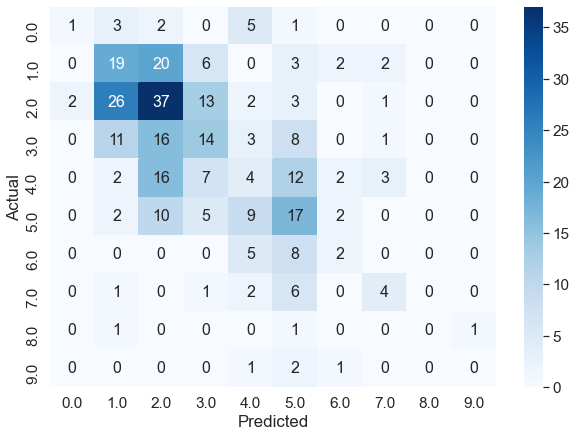

In [35]:
# load model and results
filename = './models/' + nb_long_id + '_dnn_model'
model = keras.models.load_model(filename)

filename = './models/' + nb_long_id + '_dnn_results.pkl'
history, dnn_score, dnn_cm = pickle.load(open(filename,'rb'))

predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

In [36]:
# Evaluate performance on Test set2

X_test_scaled = AtPsy_X_test_scaled

predictions = model.predict(X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_AtPsy_predict.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a_At_dnn_test_AtPsy_predict.pkl


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### XGBoost
XGBoost is an implementaplotscriben of gradient boosted decision trees designed for speed and performance.

#### Train

In [ ]:
xgb = XGBClassifier()

t0 = time.time()
xgb.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

##### Features importance

In [ ]:
node_features = xgb.feature_importances_
node_features_dict = {At_list[i]: node_features[i] for i in range(len(At_list))}
node_ranking_dict = {k: v for k, v in sorted(node_features_dict.items(), key=lambda item: item[1], reverse=True)}

filename = f"../results/03_At/features/{nb_long_id}_xgb.npy"
np.save(filename,node_ranking_dict)
print(f"Written to: {filename}")

In [ ]:
filename = f"../results/03_At/features/{nb_long_id}_xgb.npy"

node_ranking_dict = np.load(filename, allow_pickle=True)
node_ranking_dict = node_ranking_dict.item()

topN = None # 3500
plt.plot(list(node_ranking_dict.values())[0:topN])
plt.yscale("log")
plt.title('XGB ranked fnb_long_id importance')
# plt.xticks()
plt.xlabel('top features')
plt.ylabel('Importance')
plt.show()

#### Test1

In [ ]:
xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

filename = f"./models/{nb_long_id}_xgb_model_results.pkl"
pickle.dump([xgb, xgb_score, xgb_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [54]:
xgb_y_pred = xgb.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_predict.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a_At_xgb_test_predict.pkl


array([5., 5., 2., 5., 8., 5.])

#### Test3 AtPsy

Accuracy:	 30.18%
Precision:	 17.39%
Recall:		 17.79%
F1 score:	 17.19%


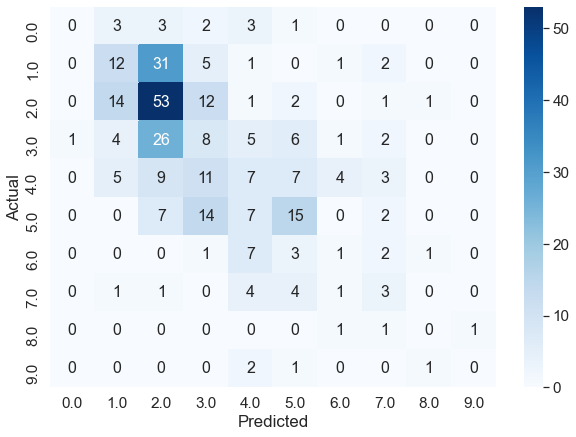

In [30]:
filename = './models/' + nb_long_id + '_xgb_model_results.pkl'
xgb, xgb_score, xgb_cm = pickle.load(open(filename,'rb'))

xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

In [39]:
X_test_scaled = AtPsy_X_test_scaled

xgb_y_pred = xgb.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_AtPsy_predict.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a_At_xgb_test_AtPsy_predict.pkl


array([5., 3., 4., 3., 5., 4., 5., 6., 4., 2., 6., 5., 5., 5., 5., 4., 4.,
       4., 5., 4., 5., 5., 5., 3., 5., 5., 3., 4., 5., 5., 5., 5., 5., 4.,
       4., 4., 4., 3., 4., 5., 5., 4., 4., 5., 4., 4., 3., 5., 5., 0., 5.,
       0., 5., 4., 5., 4., 4., 4., 5., 5., 4., 5., 4., 5., 5., 5., 4., 5.,
       5., 5., 5., 6., 5., 5., 4., 4., 5., 5., 5., 5., 5., 5., 4., 5., 5.,
       5., 4., 5., 4., 5., 5., 5., 4., 3., 4., 4., 5., 4., 5., 6.])

### Random Forest

#### Train

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)

t0 = time.time()
rf.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

##### Features importance

In [ ]:
node_features = rf.feature_importances_
node_features_dict = {At_list[i]: node_features[i] for i in range(len(At_list))}
node_ranking_dict = {k: v for k, v in sorted(node_features_dict.items(), key=lambda item: item[1], reverse=True)}

filename = f"../results/03_At/features/{nb_long_id}_rf.npy"
np.save(filename,node_ranking_dict)
print(f"Written to: {filename}")

In [ ]:
filename = f"../results/03_At/features/{nb_long_id}_rf.npy"

node_ranking_dict = np.load(filename, allow_pickle=True)
node_ranking_dict = node_ranking_dict.item()

topN = None
plt.plot(list(node_ranking_dict.values())[0:topN])
plt.yscale("log")
plt.title('XGB ranked feature importance')
# plt.xticks()
plt.xlabel('top features')
plt.ylabel('Importance')
plt.show()

#### Test1

In [ ]:
rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

filename = f"./models/{nb_long_id}_rf_model_results.pkl"
pickle.dump([rf, rf_score, rf_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [55]:
rf_y_pred = rf.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_predict.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a_At_rf_test_predict.pkl


array([2., 2., 2., 3., 2., 5.])

#### Test3 AtPsy

Accuracy:	 33.84%
Precision:	 23.02%
Recall:		 22.10%
F1 score:	 21.79%


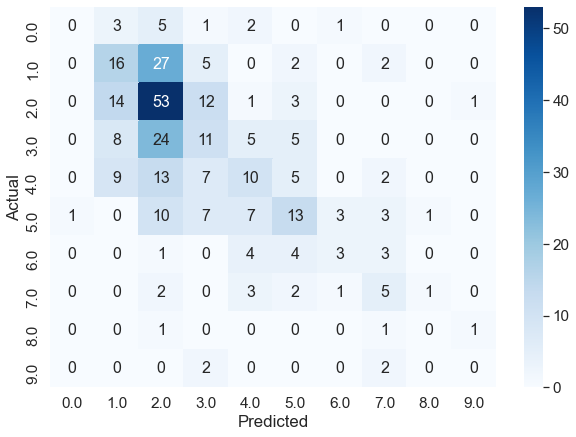

In [40]:
filename = './models/' + nb_long_id + '_rf_model_results.pkl'
rf, rf_score, rf_cm = pickle.load(open(filename,'rb'))

rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

In [43]:
X_test_scaled = AtPsy_X_test_scaled
rf_y_pred = rf.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_AtPsy_predict.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a_At_rf_test_AtPsy_predict.pkl


array([5., 5., 3., 5., 7., 5., 5., 5., 5., 5., 5., 2., 5., 4., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 4., 5., 2., 5., 5., 3., 5., 3., 5., 5.,
       2., 5., 5., 5., 5., 5., 5., 5., 5., 1., 5., 2., 5., 5., 5., 5., 2.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 5., 3., 5., 5.,
       5., 2., 5., 2., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

### SVM
#### RBF kernel
##### Train

In [ ]:
#Create a svm Classifier
svm = SVC() 

t0 = time.time()
svm.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

##### Test1

In [ ]:
#Predict the response for test dataset
svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

filename = f"./models/{nb_long_id}_svm_model_results.pkl"
pickle.dump([svm, svm_score, svm_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

##### Test2

In [56]:
#Predict the response for test dataset
svm_y_pred = svm.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_predict.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a_At_svm_test_predict.pkl


array([2., 2., 2., 2., 2., 5.])

##### Test3 AtPsy

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 29.27%
Precision:	 18.89%
Recall:		 17.76%
F1 score:	 17.57%


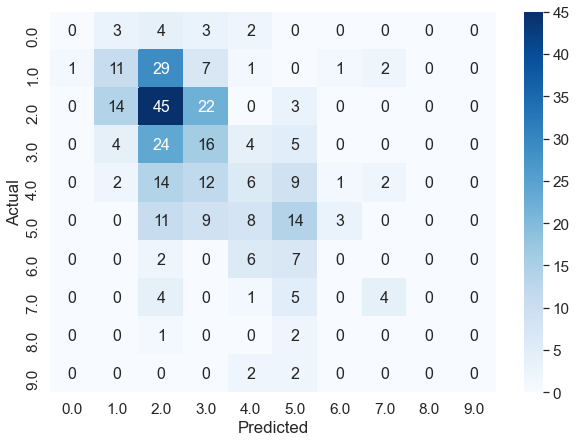

In [44]:
filename = './models/' + nb_long_id + '_svm_model_results.pkl'
svm, svm_score, svm_cm = pickle.load(open(filename,'rb'))

svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

In [45]:
#Predict the response for test dataset

X_test_scaled = AtPsy_X_test_scaled
svm_y_pred = svm.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_AtPsy_predict.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a_At_svm_test_AtPsy_predict.pkl


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

#### Linear kernel
##### Train

In [ ]:
#Create a svm Classifier
svm_lin = SVC(kernel='linear') # Linear Kernel

t0 = time.time()
#Train the model using the training sets
svm_lin.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

##### Test1

In [ ]:
svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

filename = f"./models/{nb_long_id}_svm_lin_model_results.pkl"
pickle.dump([svm_lin, svm_lin_score, svm_lin_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

##### Test2

In [57]:
svm_lin_y_pred = svm_lin.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_predict.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a_At_svm_lin_test_predict.pkl


array([1., 2., 1., 3., 3., 5.])

##### Test3 AtPsy

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 32.32%
Precision:	 21.61%
Recall:		 19.87%
F1 score:	 20.01%


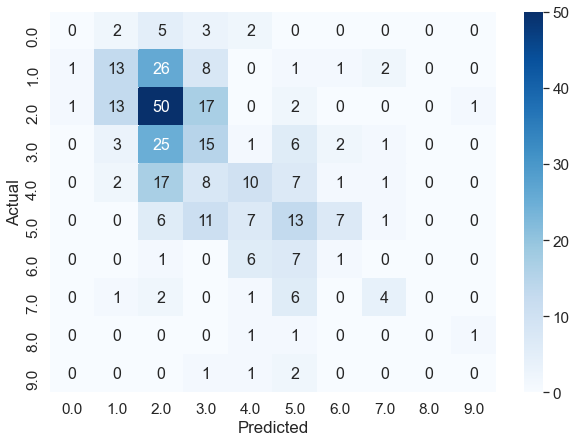

In [46]:
filename = './models/' + nb_long_id + '_svm_lin_model_results.pkl'
svm_lin, svm_lin_score, svm_lin_cm = pickle.load(open(filename,'rb'))

svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

In [47]:
X_test_scaled = AtPsy_X_test_scaled

svm_lin_y_pred = svm_lin.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_AtPsy_predict.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a_At_svm_lin_test_AtPsy_predict.pkl


array([2., 3., 2., 3., 4., 4., 5., 2., 2., 2., 0., 0., 8., 2., 2., 2., 2.,
       2., 2., 3., 2., 3., 2., 2., 2., 3., 2., 3., 2., 2., 2., 3., 0., 0.,
       2., 0., 2., 2., 2., 2., 2., 2., 2., 3., 2., 4., 3., 2., 5., 3., 3.,
       3., 2., 2., 2., 5., 4., 5., 3., 5., 2., 5., 3., 2., 5., 5., 5., 2.,
       5., 5., 5., 2., 4., 2., 2., 5., 5., 5., 4., 5., 5., 4., 2., 2., 4.,
       4., 2., 3., 3., 5., 2., 2., 2., 2., 4., 4., 2., 2., 4., 5.])

## Prediction
### Arabidopsis mock data

In [ ]:
# model, score, cm, dnn_history = fetch_data_metrics(nb_long_id)
# print(f'Loading results from nb_id: {nb_id}')

In [ ]:
# df_mock = pd.read_csv("../data/raw/AtBcMicroArray2012/AtBc16hpiMock_2012_IDConver.csv")

# mock_features = df_mock.loc[:,'GeneID']
# mock_features.to_list()

# print(f'Number of features: {len(mock_features)}')
# print(f'Unique features: {len(set(mock_features))}')

# ugene_names = [each_string.upper() for each_string in At_list]
# common_features = set(mock_features) & set(ugene_names)
# print(f'Intersection: {len(common_features)}')

# cols = df.columns.to_list()
# cols = cols[6:20346]
# df2 = pd.DataFrame(columns=cols)
# df2.loc[len(df2)] = 0

# mock_gene_list = df_mock['GeneID'].to_list()

# for gene in common_features:
#     df2.loc[0,gene] = df_mock.loc[df_mock['GeneID'] == gene,'Microarray'].values[0]

# df2

In [ ]:
# # # Generate standardized test features 
# # At_X_test = np.zeros((6,len(gene_names)))
# # At_X_test[:20340, :20340] = df_test.to_numpy()

# # # scale test features based on training data
# # At_X_test_scaled = scaler.transform(At_X_test)
# # print(np.shape(At_X_test_scaled))
# # At_X_test_scaled


# # X_test = df2.loc[0].to_numpy(dtype='float')
# X_test = np.zeros((6,len(gene_names)))
# X_test[:, :20340] = df2.to_numpy()

# # X_test = df2.values
# # X_test = X_test.astype('float')

# X_test_scaled = scaler.transform(X_test)

# predictions = model['dnn'].predict(X_test_scaled)
# dnn_y_pred = np.argmax(predictions, 1)
# xgb_y_pred = model['xgb'].predict(X_test_scaled)
# rf_y_pred = model['rf'].predict(X_test_scaled)
# svm_y_pred = model['svm'].predict(X_test_scaled)
# svm_lin_y_pred = model['svm_lin'].predict(X_test_scaled)

# print(f'DNN predicted class: {dnn_y_pred}')
# print(f'XGB predicted class: {xgb_y_pred}')
# print(f'RF predicted class: {rf_y_pred}')
# print(f'SVM predicted class: {svm_y_pred}')
# print(f'linSVM predicted class: {svm_lin_y_pred}')

In [ ]:
# X_test_scaled[0,0:10]

### Arabidopsis infection data

In [ ]:
# df_infect = pd.read_csv("../data/raw/AtBcMicroArray2012/AtBc16hpiInfe_2012_IDConver.csv")

# infect_features = df_infect.loc[:,'GeneID']
# infect_features.to_list()

# print(f'Number of features: {len(infect_features)}')
# print(f'Unique features: {len(set(infect_features))}')

# ugene_names = [each_string.upper() for each_string in gene_names]
# common_features = set(infect_features) & set(ugene_names)
# print(f'Intersection: {len(common_features)}')

# cols = df.columns.to_list()
# cols = cols[6:20346]
# df2 = pd.DataFrame(columns=cols)
# df2.loc[len(df2)] = 0

# infect_gene_list = df_infect['GeneID'].to_list()

# for gene in common_features:
#     df2.loc[0,gene] = df_infect.loc[df_infect['GeneID'] == gene,'Microarray'].values[0]

# df2

In [ ]:
# # X_test = df2.loc[0].to_numpy(dtype='float')
# X_test = df2.values
# X_test = X_test.astype('float')

# X_test_scaled = scaler.transform(X_test)

# predictions = model['dnn'].predict(X_test_scaled)
# dnn_y_pred = np.argmax(predictions, 1)
# xgb_y_pred = model['xgb'].predict(X_test_scaled)
# rf_y_pred = model['rf'].predict(X_test_scaled)
# svm_y_pred = model['svm'].predict(X_test_scaled)
# svm_lin_y_pred = model['svm_lin'].predict(X_test_scaled)

# print(f'DNN predicted class: {dnn_y_pred}')
# print(f'XGB predicted class: {xgb_y_pred}')
# print(f'RF predicted class: {rf_y_pred}')
# print(f'SVM predicted class: {svm_y_pred}')
# print(f'linSVM predicted class: {svm_lin_y_pred}')

In [ ]:
# X_test_scaled[0,0:10]

## Plots
### Performance metrics

**Precision** is a measure of the ability of a classification model to identify only the relevant data points.<br>
**Recall** is a measure of the ability of a model to find all the relevant cases within a dataset.

In [ ]:
max_ylim = 0.5
file_out = f'./figures/{nb_id}_AtOnly_score_class{num_classes}.pdf'
fig_title = 'At only features'
# df_metrics = plot_performance_metrics(nb_id, max_ylim, file_out, fig_title)
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title)
df_metrics

#### Fuzzy results

In [ ]:
max_ylim = 0.8
offset = 1
file_out = f'./figures/{nb_id}_AtOnly_fuzzy_score_class{num_classes}.pdf'
fig_title = f'At only features (class offset tolerance = {offset})'
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, offset)
df_metrics

### MSE

In [ ]:
total_class_mse, class_mse, class_rss = class_error(dnn_cm)
total_class_mse

max_ylim = 3.5
file_out = f'./figures/{nb_id}_AtOnly_mse_class{num_classes}.pdf'
fig_title = f'At only features, class MSE'
df_metrics = plot_mse(nb_long_id, max_ylim, file_out, fig_title)
df_metrics

### Prediction

In [58]:
cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
df_test2_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

print(f"{nb_long_id} Test Predictions")


filename = f"../results/03_At/prediction/{nb_long_id}_test_predictions.pkl"
# filename = f"../results/03_At/prediction/{nb_long_id}_test_AtPsy_predictions.pkl"

pickle.dump(df_test2_predict, open(filename, 'wb'))
print(f"Written to: {filename}")

df_test2_predict

03a_At Test Predictions
Written to: ../results/03_At/prediction/03a_At_test_predictions.pkl


,DNN,XGB,RF,SVM,linSVM
0,2.0,5.0,2.0,2.0,1.0
1,2.0,5.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,1.0
3,3.0,5.0,3.0,2.0,3.0
4,3.0,8.0,2.0,2.0,3.0
5,1.0,5.0,5.0,5.0,5.0


In [59]:
df = get_prediction_df(nb_long_id)
df

,dnn,xgb,rf,svm,svm_lin
0,2.0,5.0,2.0,2.0,1.0
1,2.0,5.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,1.0
3,3.0,5.0,3.0,2.0,3.0
4,3.0,8.0,2.0,2.0,3.0
5,1.0,5.0,5.0,5.0,5.0


In [60]:
filename = f"../results/03_At/prediction/{nb_long_id}_test_AtPsy_predictions.pkl"

f = open(filename, 'rb')
df_AtPsy_prediction = pickle.load(f)
f.close()

df_AtPsy_prediction

,DNN,XGB,RF,SVM,linSVM
0,2.0,5.0,5.0,2.0,2.0
1,2.0,3.0,5.0,2.0,3.0
2,2.0,4.0,3.0,2.0,2.0
3,2.0,3.0,5.0,2.0,3.0
4,2.0,5.0,7.0,2.0,4.0
...,...,...,...,...,...
95,2.0,4.0,5.0,2.0,4.0
96,2.0,5.0,5.0,2.0,2.0
97,2.0,4.0,5.0,2.0,2.0
98,2.0,5.0,5.0,2.0,4.0


## Others